# <center> Fruit Identification using a CNN  </center> <br> 
### <center> Keras/TensorFow </center><br> 
<center> Dr.-Ing. Daniel Lachner-Piza </center>
<center> AI and ML Bootcamp 2023 </center>



---
Data Set: https://www.kaggle.com/datasets/moltean/fruits

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import img_to_array
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, accuracy_score

**ImageDataGenerator**<br><br>
The ImageDataGenerator specifies how the images that will be loaded are to be used for training.
Using a generator improves the model, because we are 'generating' additional images above and beyond
the available images to train the model on. 

In this case, we are allowing images to be created that are rescaled to a values between 0 - 1
(optimizes training - value, shape and number of images doesn't change), THEN they are:

- distorted to a max shear degree (check out https://www.tutorialspoint.com/javafx/shearing_transformation),
- randomly zoomed in or out within the defined range and (additional images created)
- are mirror flipped (doubling the initial number of images!)  

This basically gives the computer a 'look' at many variation of the same object without requiring additional source data.
We do not augment the test data as we are simplying validating the trained model the actual images are sufficient.

In [2]:
train_datagen = ImageDataGenerator(rescale=1/255., rotation_range=15, shear_range = 0.2, width_shift_range=0.2, 
                                   height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255.)

In [3]:
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True,)

# test_datagen = ImageDataGenerator(rescale = 1./255,)

**Locate and assign Training Set using the Keras built in capability to read from directory**<br><br>
Point to the file path on your own computer!
Notes:
- 'binary' is looking for only 2 folders for classes. Categorical for multiclass
- Shuffle is True because we read these images in, in order, but we don't want to train all
  of one category then the next, it will bias the model, so we want to shuffle
- 64 refers to the size of matrix we want to save the pixel data in.   

In [4]:
img_size = 100
batch_size = 32

train_set_path = "fruits-360-original-size/Training"
test_set_path = "fruits-360-original-size/Test"
#test_set_path = "fruits-360/Test"
#test_set_path = "fruits-360/Test"


training_set = train_datagen.flow_from_directory(train_set_path, target_size = (img_size, img_size), batch_size = batch_size, class_mode = 'categorical', shuffle = True)
#train_generator = train_datagen.flow_from_directory(train_set_path, target_size=(img_size, img_size), batch_size=batch_size, shuffle=True, class_mode='sparse')

Found 6231 images belonging to 24 classes.


**Locate and assign Test Set**

Note shuffle = False, so we can compare the labels with the images for sanity checking

In [5]:
test_set = test_datagen.flow_from_directory(test_set_path, target_size = (img_size, img_size), batch_size = batch_size, class_mode = 'categorical', shuffle = False)
#test_generator = test_datagen.flow_from_directory(test_set_path, target_size=(img_size, img_size), batch_size=batch_size, shuffle=False, class_mode='sparse')

Found 3110 images belonging to 24 classes.


# Visualize data shape

In [6]:
print("Train Data = ", len(training_set.filepaths))
print("Test Data = ", len(test_set.filepaths))

Train Data =  6231
Test Data =  3110


# Get number of classes

In [7]:
classes_ids = np.unique(training_set.labels)
print("Number of classes = ", len(classes_ids))

Number of classes =  24


# Display a training sample from each class

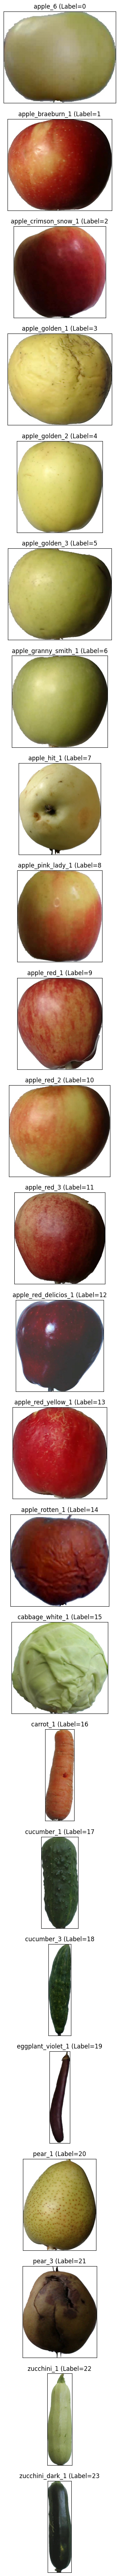

In [8]:
classes_ids = np.unique(training_set.labels)
f, axes = plt.subplots(len(classes_ids),1, figsize=(2, len(classes_ids)*2))
f.tight_layout()

for cidx, class_id in enumerate(classes_ids):
    class_samples_idxs = np.argwhere(training_set.labels == class_id).ravel()
    image_idx = class_samples_idxs[0]
    image_path = training_set.filepaths[image_idx]
    
    image_label = os.path.dirname(image_path) # only OK if shuffle=false
    class_name = image_label.split("\\")[-1]
    class_label = training_set.labels[image_idx]

    image_obj = mpimg.imread(image_path)
    image_obj = image_obj/255
    image_obj = img_to_array(image_obj)
    ax=axes[cidx]
    ax.imshow(image_obj)
    ax.set_title(f"{class_name} (Label={class_label}")
    ax.set_xticks([])
    ax.set_yticks([])


# Design the CNN Architecture

In [9]:
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 128, activation = 'relu'))

# Output layer must be the same size as number of classes
classifier.add(Dense(units = 24, activation = 'softmax'))

# Compile CNN <br>
Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) and categorical crossentropy when one sample can have multiple classes or labels are soft probabilities (like [0.5, 0.3, 0.2]).

In [12]:
# or sparse_categorical_crossentropy
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                   

# Train the CNN

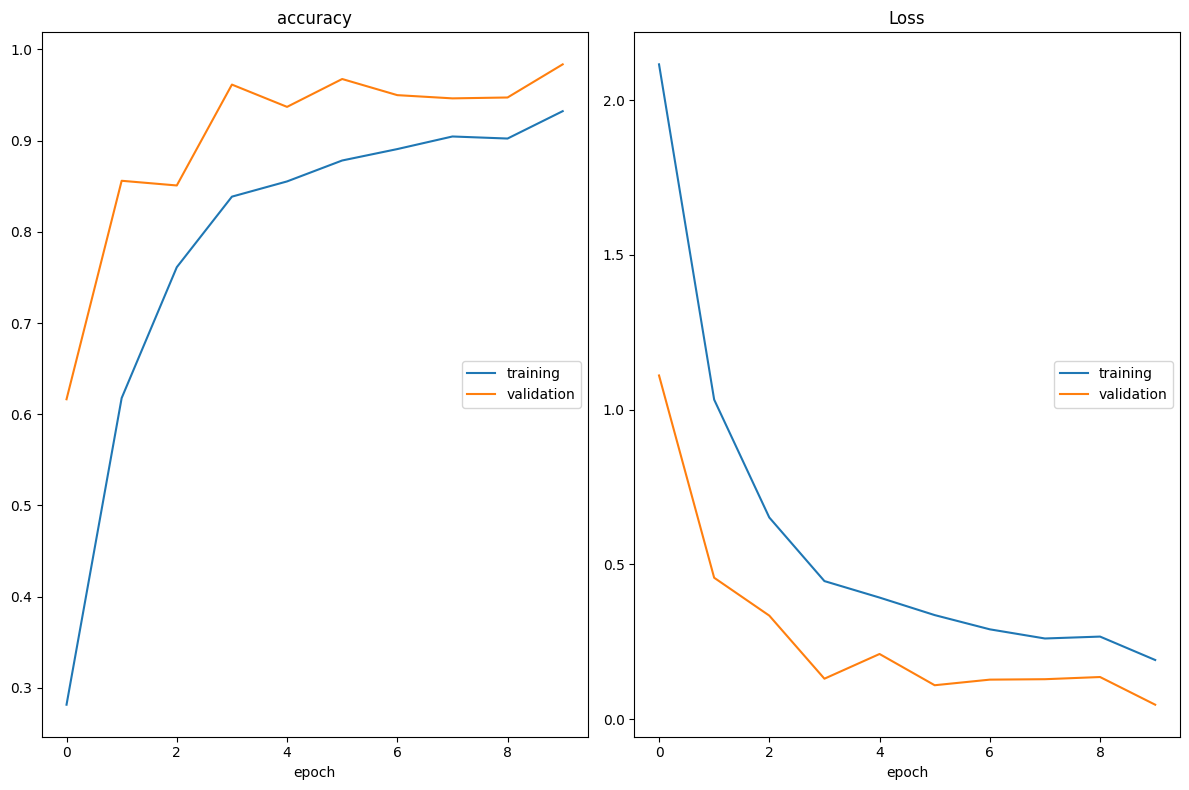

accuracy
	training         	 (min:    0.281, max:    0.932, cur:    0.932)
	validation       	 (min:    0.616, max:    0.984, cur:    0.984)
Loss
	training         	 (min:    0.191, max:    2.115, cur:    0.191)
	validation       	 (min:    0.046, max:    1.110, cur:    0.046)


In [13]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
classifier.fit(training_set,
               epochs = 30,
               validation_data = test_set,
               callbacks=[PlotLossesKeras()],
               verbose=0)

# Test the CNN

In [27]:
y_pred = classifier.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
y_test = test_set.labels

98/98 [==============================] - 5s 47ms/step


In [51]:
print(y_pred.shape)
print(y_test.shape)

(3110,)
(3110,)


In [52]:
cm_results = confusion_matrix(y_test.ravel(), y_pred.ravel())
display(cm_results)

array([[152,   0,   0,   0,   0,   0,   0,   5,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 134,   0,   0,   0,   0,   0,   0,   0,   0,  26,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 159,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 154,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 154,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 158,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 160,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0

In [ ]:
accuracy_per_class = cm_results.diagonal()/cm_results.sum(axis=1)
avg_accuracy = np.mean(accuracy_per_class)
print(avg_accuracy)

In [46]:
accuracy_score(y_test, y_pred)

0.9836012861736334